In [121]:
import numpy as np
import os, pickle, sys
from scipy.io import loadmat
import matplotlib.pyplot as plt
from glob import glob
from torch.utils import data
from scipy import ndimage
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
import utils, cv2
# Plot config
plt.style.use([os.path.join(os.getcwd(), "style.mplstyle")])

### Helper functions

### Plot figures

In [2]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Data loaders ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
train_dataset_files = glob(os.path.join(os.getcwd(), '..', 'data', 'bottom', 'train', '*'))
test_dataset_files = glob(os.path.join(os.getcwd(),  '..', 'data', 'bottom', 'test', '*'))

train_masks_sum = np.array([])
for dataset_file in train_dataset_files:
    if 'goldberg' in dataset_file and 'bottom' in dataset_file:
        rotate = True   
    else:
        rotate = False
    _, masks, _ = utils.load_data(dataset_file, image_field_name='imgs', mask_field_name='masks', rotate=rotate)
    labels_sum = np.sum(masks.reshape(masks.shape[0], -1), axis=-1)
    train_masks_sum = np.append(train_masks_sum, labels_sum)

test_masks_sum = np.array([])
for dataset_file in test_dataset_files:
    if 'goldberg' in dataset_file and 'bottom' in dataset_file:
        rotate = True   
    else:
        rotate = False
    _, masks, _ = utils.load_data(dataset_file, image_field_name='imgs', mask_field_name='masks', rotate=rotate)
    labels_sum = np.sum(masks.reshape(masks.shape[0], -1), axis=-1)
    test_masks_sum = np.append(test_masks_sum, labels_sum)

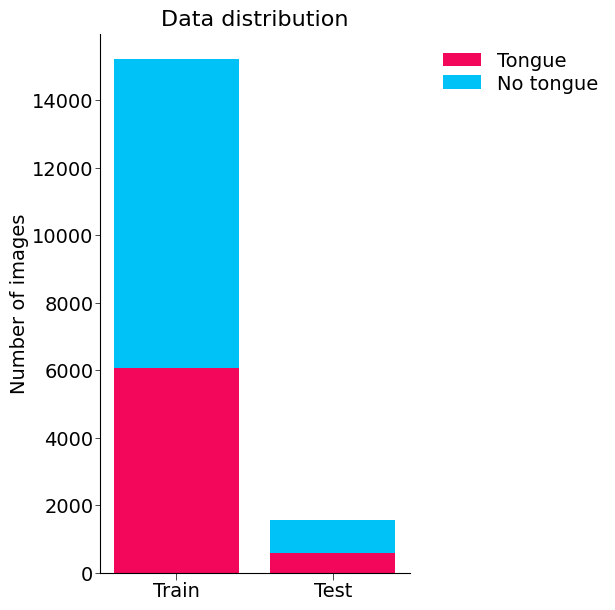

In [3]:
# Plot a stacked bar chart showing how many sum more than 0 and how many sum more == 0
train_tongue_count = np.sum(train_masks_sum > 0)
train_no_tongue_count = np.sum(train_masks_sum == 0)
test_tongue_count = np.sum(test_masks_sum > 0)
test_no_tongue_count = np.sum(test_masks_sum == 0)
plt.figure(figsize=(4, 7))
plt.bar('Train', train_tongue_count, color='#f3075a')
plt.bar('Train', train_no_tongue_count, bottom=train_tongue_count, color='#00c2f7')
plt.bar('Test', test_tongue_count, color='#f3075a')
plt.bar('Test', test_no_tongue_count, bottom=test_tongue_count, color='#00c2f7')
plt.title('Data distribution')
plt.ylabel('Number of images')
plt.legend(["Tongue", "No tongue"], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

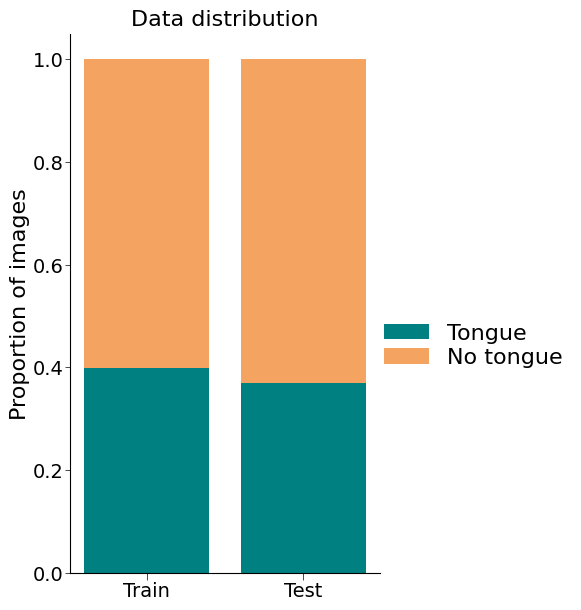

In [49]:
# Plot proportion of tongue and no tongue
train_tongue_proportion = train_tongue_count / (train_tongue_count + train_no_tongue_count)
test_tongue_proportion = test_tongue_count / (test_tongue_count + test_no_tongue_count)
plt.figure(figsize=(4, 7))
plt.bar('Train', train_tongue_proportion, color='teal')
plt.bar('Train', 1-train_tongue_proportion, bottom=train_tongue_proportion, color='sandybrown')
plt.bar('Test', test_tongue_proportion, color='teal')
plt.bar('Test', 1-test_tongue_proportion, bottom=test_tongue_proportion, color='sandybrown')
plt.title('Data distribution')
plt.ylabel('Proportion of images', fontsize=16)
plt.legend(["Tongue", "No tongue"], bbox_to_anchor=(.95, .5), loc='upper left', fontsize=16)
# save figure
plt.savefig(os.path.join(os.getcwd(), 'data_distribution.png'), bbox_inches='tight')
plt.show()


In [5]:
train_dataset = utils.get_dataset(train_dataset_files, 'bottom', train=True)
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=4, num_workers=16)

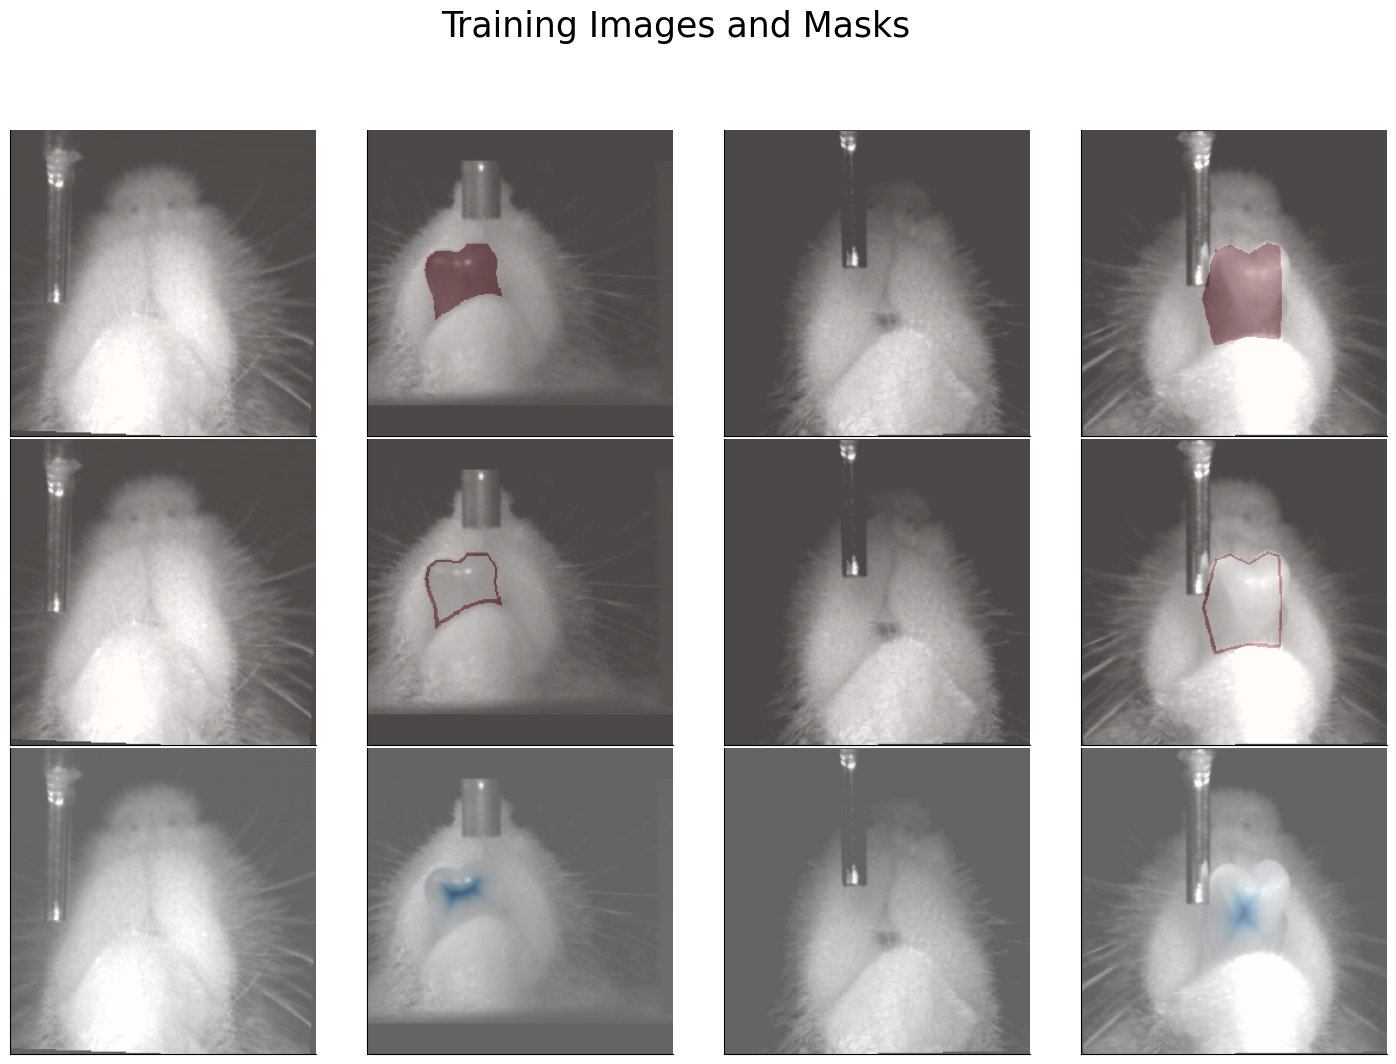

In [35]:
# Plot example images from train and test set
# Get a batch of training data
batch_data = next(iter(train_loader))
inputs, masks, mask_edges, mask_dist_to_boundary = batch_data['image'], batch_data['mask'], batch_data['mask_edges'], batch_data['mask_dist_to_boundary']
# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(18, 12))
for idx in np.arange(4):
    ax = fig.add_subplot(3, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(inputs[idx].numpy().squeeze(), cmap='gray')
    plt.imshow(masks[idx].numpy().squeeze(), alpha=0.3, cmap='Reds')
    ax = fig.add_subplot(3, 4, idx+5, xticks=[], yticks=[])
    plt.imshow(inputs[idx].numpy().squeeze(), cmap='gray')
    plt.imshow(mask_edges[idx].cpu().numpy().squeeze(), cmap='Reds', alpha=0.3)
    ax = fig.add_subplot(3, 4, idx+9, xticks=[], yticks=[])
    plt.imshow(inputs[idx].numpy().squeeze(), cmap='gray')
    plt.imshow(mask_dist_to_boundary[idx].cpu().numpy().squeeze(), cmap='Blues', alpha=0.4)
# Adjust spacing between plots 
plt.subplots_adjust(wspace=0.1, hspace=0.01)
fig.suptitle('Training Images and Masks', fontsize=25)
# save figure
plt.savefig(os.path.join(os.getcwd(), 'training_sample.png'), bbox_inches='tight')
plt.show()


In [89]:
imgs, masks, _ = utils.load_data(train_dataset_files[0], image_field_name='imgs', mask_field_name='masks', rotate=True)

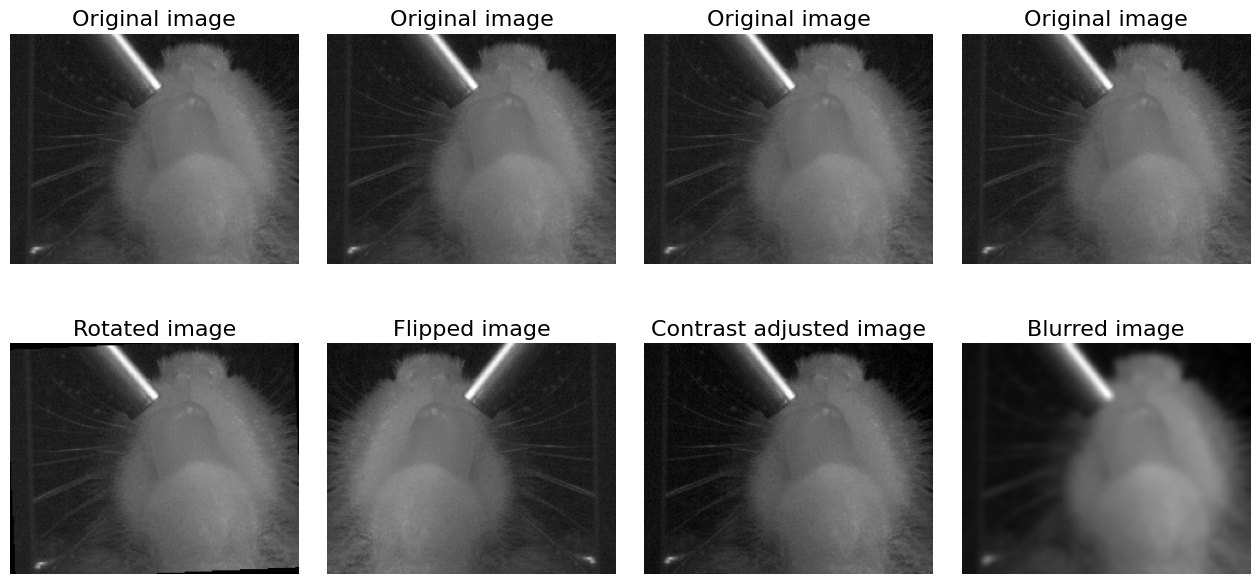

In [136]:
# Plot a figure with different columns where each column shows the different augmentation techniques. First row shows the original image, second row shows augmented image.
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
idx = 130 #130
for i in range(ax.shape[1]): 
    ax[0,i].imshow(imgs[idx], cmap='gray')
    ax[0,i].set_title('Original image')
    ax[0,i].axis('off')
    ax[1,i].axis('off')
# Rotate image
rotate_range = 5
theta = 1 * rotate_range - rotate_range / 2
rotated_img =  ndimage.rotate(imgs[idx], theta, axes=(-2, -1), reshape=False).copy()
flipped_img =  cv2.flip(imgs[idx], 1) #ndimage.rotate(imgs[idx], 180, axes=(0, -1), reshape=False)
contrast_img = utils.randomly_adjust_contrast(imgs[idx])
blurred_img = utils.blur_image(imgs[idx], type='gaussian')
ax[1,0].imshow(rotated_img, cmap='gray')
ax[1,0].set_title('Rotated image')
ax[1,1].imshow(flipped_img, cmap='gray')
ax[1,1].set_title('Flipped image')
ax[1,2].imshow(contrast_img, cmap='gray')
ax[1,2].set_title('Contrast adjusted image')
ax[1,3].imshow(blurred_img, cmap='gray')
ax[1,3].set_title('Blurred image')
plt.subplots_adjust(wspace=0.1, hspace=0.01)
plt.savefig(os.path.join(os.getcwd(), 'augmentation.png'), bbox_inches='tight')